In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

# Load the macro data and parse the unnamed date column
macro = pd.read_csv('../data/cleaned_macro_data.csv', parse_dates=['Unnamed: 0'])

# Rename the date column properly and set as index
macro.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
macro.set_index('Date', inplace=True)

# Ensure proper datetime index and sort
macro.index = pd.to_datetime(macro.index)
macro = macro.sort_index()

# Optional: remove duplicate date rows by averaging or keeping first
macro = macro.groupby(macro.index).mean()

# Check again
print(macro.head())
print("\nIndex Range:", macro.index.min(), "to", macro.index.max())

# Load cleaned macro data
macro = pd.read_csv('../data/cleaned_macro_data.csv', index_col=0)
macro.index = pd.to_datetime(macro.index)
macro.index.name = 'Date'
macro = macro.sort_index()

# Simulate Tata stock prices (or replace this with real if available)
dates = macro.index
np.random.seed(42)
base_price = 450
returns = np.random.normal(loc=0.005, scale=0.04, size=len(dates))
prices = base_price * (1 + returns).cumprod()

tata = pd.DataFrame(index=dates)
tata['Close'] = prices
tata['Returns'] = tata['Close'].pct_change()

# Merge macro + Tata returns
merged = pd.concat([macro, tata['Returns']], axis=1)
merged.dropna(inplace=True)

print(merged[['Total_Sales', 'CPI', 'Repo']].head(15))
signal_df.to_csv('../outputs/macro_signals.csv')

            Total_Sales   CPI  Repo  Reverse_Repo
Date                                             
2018-01-01     254493.0  5.07   NaN           NaN
2018-02-01     262123.0  4.44   NaN           NaN
2018-03-01     257477.0  4.28   NaN           NaN
2018-04-01     254954.0  4.58   NaN           NaN
2018-05-01     244977.0  4.87   NaN           NaN

Index Range: 2018-01-01 00:00:00 to 2024-12-31 00:00:00
Empty DataFrame
Columns: [Total_Sales, CPI, Repo]
Index: []


NameError: name 'signal_df' is not defined

In [21]:
# Create Signals from macro data

# Signal 1: Year-over-Year Auto Sales Growth
macro['Auto_YoY'] = macro['Total_Sales'].pct_change(periods=12) * 100

# Signal 2: 3-month Repo Rate Delta
macro['Repo_Change3M'] = macro['Repo'].diff(periods=3)

# Signal 3: CPI Acceleration (3-month forward difference)
macro['CPI'] = pd.to_numeric(macro['CPI'], errors='coerce')
macro['CPI_Accel'] = macro['CPI'].diff(periods=3)

# Target variable: Simulated Returns (as YoY % change in auto sales)
macro['Returns'] = macro['Total_Sales'].pct_change() * 100

# Drop rows with NaNs introduced by lagging
macro_signals = macro[['Auto_YoY', 'Repo_Change3M', 'CPI_Accel', 'Returns']].dropna()

# Check signal data
print(macro_signals.head())

# Save for modeling
macro_signals.to_csv('../data/signal_dataset.csv')

macro_signals.to_csv('../outputs/macro_signals.csv')

             Auto_YoY  Repo_Change3M  CPI_Accel   Returns
Date                                                     
2023-02-01   2.226479           0.00       0.72  6.051265
2023-02-28   2.330496           0.25      -0.08  0.000000
2023-03-01  24.107674           0.25      -0.86 -4.256540
2023-03-31  19.856373           0.25      -0.78  0.000000
2023-04-01  29.271266           0.00      -1.74 -0.445376


📌 Correlation with Returns:

Returns          1.000000
Auto_YoY         0.168049
Repo_Change3M   -0.047925
CPI_Accel       -0.114565
Name: Returns, dtype: float64


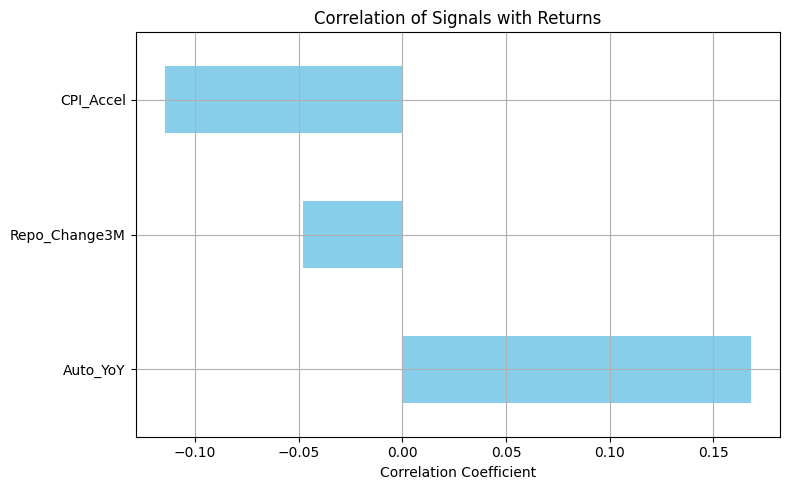


📌 Granger Causality Results (p-values):

→ Testing if Auto_YoY causes Returns:
   Lag 1 p-value: 0.4091
   Lag 2 p-value: 0.7479
   Lag 3 p-value: 0.9576

→ Testing if Repo_Change3M causes Returns:
   Lag 1 p-value: 0.8275
   Lag 2 p-value: 0.9426
   Lag 3 p-value: 0.9275

→ Testing if CPI_Accel causes Returns:
   Lag 1 p-value: 0.8641
   Lag 2 p-value: 0.7964
   Lag 3 p-value: 0.8349



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [25]:
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests

# Load signals (if not already loaded)
df = pd.read_csv('../data/signal_dataset.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# 1. Correlation matrix
corr = df.corr()
print("📌 Correlation with Returns:\n")
print(corr['Returns'].sort_values(ascending=False))

# Plot correlation bar chart
plt.figure(figsize=(8, 5))
corr['Returns'].drop('Returns').plot(kind='barh', color='skyblue')
plt.title("Correlation of Signals with Returns")
plt.xlabel("Correlation Coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
corr['Returns'].drop('Returns').plot(kind='bar', title="Correlation with Returns")
plt.tight_layout()
plt.savefig('../outputs/correlation_returns.png')
plt.close()

# 2. Granger Causality Tests
print("\n📌 Granger Causality Results (p-values):\n")
for col in ['Auto_YoY', 'Repo_Change3M', 'CPI_Accel']:
    print(f"→ Testing if {col} causes Returns:")
    result = grangercausalitytests(df[[col, 'Returns']], maxlag=3, verbose=False)
    for lag in result:
        pval = result[lag][0]['ssr_ftest'][1]
        print(f"   Lag {lag} p-value: {pval:.4f}")
    print()


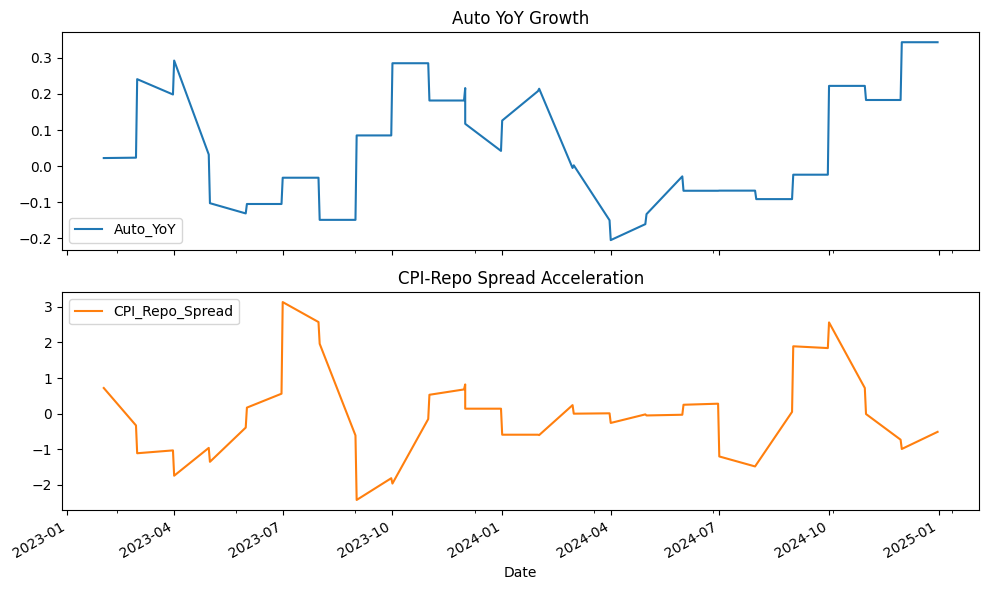

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load cleaned macro data
macro = pd.read_csv('../data/cleaned_macro_data.csv')

# Rename the date column properly and set as index
macro.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
macro.set_index('Date', inplace=True)

# Ensure proper datetime index and sort
macro.index = pd.to_datetime(macro.index)
macro = macro.sort_index()

# Signal 1: YoY Auto Sales Growth
macro['Auto_YoY'] = macro['Total_Sales'].pct_change(periods=12)

# Signal 2: CPI-Repo Spread Acceleration (3M)
macro['CPI_3M_Change'] = macro['CPI'].astype(float).diff(periods=3)
macro['Repo_3M_Change'] = macro['Repo'].diff(periods=3)
macro['CPI_Repo_Spread'] = macro['CPI_3M_Change'] - macro['Repo_3M_Change']

# Combine into final signal DataFrame
signals = macro[['Auto_YoY', 'CPI_Repo_Spread']].dropna()

# Visualize signals
signals.plot(subplots=True, figsize=(10, 6), title=['Auto YoY Growth', 'CPI-Repo Spread Acceleration'])
plt.tight_layout()
plt.show()

# Save for later model input
signals.to_csv('../data/engineered_signals.csv')



In [29]:
import os
os.makedirs('../outputs', exist_ok=True)

# Replot and save the figure
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

macro['Auto_YoY'].plot(ax=axes[0], title='Auto YoY Growth')
axes[0].legend()
axes[0].grid(True)

macro['CPI_Repo_Spread'].plot(ax=axes[1], title='CPI-Repo Spread Acceleration', color='orange')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../outputs/plot_signal_trends_combined.png', dpi=300)
plt.close()
